In [1]:
import numpy as np
import scipy.io
from math import sqrt
import scipy
import matplotlib.pyplot as plt

## Definisikan fungsi

In [2]:
# Fungsi untuk menghitung sigmoid
def sigmoid(z):
    """" 
    Hitung fungsi sigmoid pada input z, bisa skalar, vektor atau matriks
    """
    ans = 1/(1+np.exp(-z))
    return ans

# Fungsi untuk menghitung gradient sigmoid
def sigmoidgradient(z):
    """  
    Hitung fungsi gradient pada sigmoid
    """
    ans = np.multiply(sigmoid(z), (1 - sigmoid(z)))
    return ans


# Fungsi untuk inisialisasi weight secara random
def randinitialWeights(L_in, L_out):
    """
    Inisiasi nilai weight pada parameter THETA dengan dimensi
    sesuai dengan input dan output layer
    
    Return
    ------
    W: Weight dengan dimensi (L_out, L_in +1)
    Nilai +1 karena kita memiliki unit bias"""
    epsilon = sqrt(6)/(sqrt(L_in + L_out))
    W = np.random.rand(L_out, L_in + 1)*2*epsilon - epsilon
    return W


## Load Data

In [3]:


# Import MNIST dataset
mat = scipy.io.loadmat('mnist.mat')

# Import training data
data_X = mat['trainX']
data_y = mat['trainY'].T

# Normalisasi data
data_X = data_X/255.0

# Bagi training dan validasi data dengan sekitar 50000 untuk training dan 
# sisanya sekitar 10000 untuk validasi

X_train = data_X[:50000, : ]

X_val = data_X[50000:, : ]

y_train = data_y[:50000, : ]

y_val = data_y[50000:, : ]

# Importing the test set
X_test = mat['testX']
y_test = mat['testY'].T

# Normalizing the test set
X_test = X_test/255.0

In [4]:
print(data_y.shape, data_X.shape)

(60000, 1) (60000, 784)


## Visualisasi Data

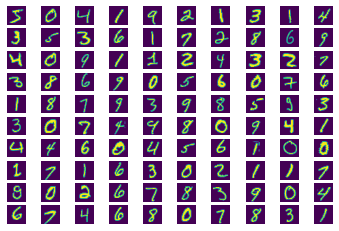

In [5]:
fig, axs = plt.subplots(10,10)
axs = axs.ravel()

for i in range(100):

    axs[i].imshow(data_X[i].reshape((28, 28)) / 255.0)
    axs[i].set_axis_off()
 

In [6]:

# Definisikan y label dengan vektor boolean
# Untuk tiap label antara 0 dan 9 kita akan memiliki vektor dengan banyaknya
# elemen sekitar 10 dimana akan bernilai 1 jika label bernilai 1

# Konversi nilai y ke boolean untuk training data 
train_labels = np.empty((len(y_train), 10))

for i in range(len(y_train)):
    x = np.arange(10)
    labels = np.array([x == y_train[i]]).astype(int)
    train_labels[i,:] = labels
    


# Konversi nilai y ke boolean untuk validasi 
val_labels = np.empty((len(y_val), 10))

for i in range(len(y_val)):
    x = np.arange(10)
    labels = np.array([x == y_val[i]]).astype(int)
    val_labels[i,:] = labels
    

# Konversi nilai y ke boolean untuk tes data
test_labels = np.empty((len(y_test), 10))

for i in range(len(y_test)):
    x = np.arange(10)
    labels = np.array([x == y_test[i]]).astype(int)
    test_labels[i,:] = labels

# Set parameter untuk neural network tanpa bias  
input_layer_size = 784
hidden_layer_size = 40
output_layer = 10

# Regularisasi
Lambda = 0.5

# Total training data
m = np.size(X_train, axis = 0)

# Inisialisasi weight dari input layer ke hidden layer dan hidden layer ke output layer
init_Theta1 = randinitialWeights(input_layer_size, hidden_layer_size)
init_Theta2 = randinitialWeights(hidden_layer_size, output_layer)

# Vektorisasi weight / flatten
weights = np.concatenate((init_Theta1.flatten(), init_Theta2.flatten()), 0)


In [7]:
Theta1 = np.reshape(weights[:np.size(init_Theta1)], newshape = np.shape(init_Theta1))
Theta2 = np.reshape(weights[np.size(init_Theta1):], newshape = np.shape(init_Theta2))

In [8]:
# Propagasi forward
def forwardpropogation(X, param1, param2):
    """ 
    Implementasi dari propagasi forward dari neural network
    dengan menggunakan sigmoid
     
    X: data
    param1: weight dari input layer ke hidden layer
    param2: weight dari hidden layer ke output layer
    
    Return
    ------
    z3: aktifasi dari hidden layer
    z2: aktifasi dari output layer
    """
    
    
    # Adding a column of ones which we will be our bias unit
    X = np.hstack((np.ones((len(X), 1)), X))
    
    a2 = np.dot(X, param1.T)

    z2 = sigmoid(a2)

    z2 = np.hstack((np.ones((len(z2), 1)), z2))
    
    a3 = np.dot(z2, param2.T)
    z3 = sigmoid(a3)
    
    return (z2, z3)


# Propagasi backward
def backpropagation(weights, *args):
    
    """ 
    Hitung fungsi cost dengan regularisasi pada neural network
    dan hitung gradient untuk fungsi cost
    
    weights: vektor yang memiliki nilai inisialisasi
    X : Data pixel pada tiap gambar  
    y : Label dengan elemen boolean
    Lambda : Parameter regularisasi
    
    Retur
    -----
    J: Fungsi cost
    grad: gradient
    
    """
    X, y, Lambda = args
    
    # Variabel weight
    Theta1 = np.reshape(weights[:np.size(init_Theta1)], newshape = np.shape(init_Theta1))
    Theta2 = np.reshape(weights[np.size(init_Theta1):], newshape = np.shape(init_Theta2))

    # Hitung propagasi forward untuk aktifasi dari hidden ke layer keluaran
    z2, z3 = forwardpropogation(X = X_train, param1=Theta1, param2=Theta2)
    
    # Bias unit
    X = np.hstack((np.ones((len(X), 1)), X))
    
    # Definisi dari fungsi loss dengan regularisasi
    J = np.add(np.multiply(y, np.log(z3)), np.multiply((1 - y), np.log(1 - z3)))
    J = -np.sum(J)/len(y)
    
    # Definisikan regularisasi dan pastikan tidak menggunakan unit bias
    reg_term = np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:]))
    
    # Hitung fungsi cost dan regularisasi
    J = J + Lambda*reg_term/(2*m)
    
    # Error pada layer keluaran
    err = z3 - y
    
    # Error pada layer hidden
    d2 = np.multiply(np.dot(err, Theta2[:, 1:]), sigmoidgradient(np.dot(X, Theta1.T)))
    
    # Hitung gtadient untuk Theta1 dan Theta 2
    Theta1_grad = np.dot(d2.T, X)/m
    Theta2_grad = np.dot(err.T, z2)/m 
    # Regularisasi kecuali bias
    Theta1[:,1:] = (Lambda/m)*Theta1[:,1:]
    Theta2[:,1:] = (Lambda/m)*Theta2[:,1:]
    
    # Gradient dengan regularisasi
    Theta1_grad = np.column_stack((Theta1_grad[:,0], np.add(Theta1_grad[:,1:], Theta1[:,1:])))
    Theta2_grad = np.column_stack((Theta2_grad[:,0], np.add(Theta2_grad[:,1:], Theta2[:,1:])))
    
    # Vektorisasi/flatten gradient
    grad = np.concatenate((Theta1_grad.flatten(), Theta2_grad.flatten()), 0)
    print('Cost function ', J)
    return(J, grad)


In [9]:
import scipy.optimize

In [10]:
# Argument untuk propagasi backward
args = (X_train, train_labels, Lambda)

# Cari nilai optimal dengan menggunakan fungsi scipy
final_weights = scipy.optimize.minimize(backpropagation, weights, method = 'CG', args = args,
                       jac=True, options = {'maxiter':100})


# Nilai optimal setelah optimasi
T1 = np.reshape(final_weights.x[:np.size(init_Theta1)], newshape = np.shape(init_Theta1))
T2 = np.reshape(final_weights.x[np.size(init_Theta1):], newshape = np.shape(init_Theta2))


# Prediksi
def prediction(X, y, param1, param2):
    """ 
    Prediksi neural network dengan akurasi
    X : data gambar
    y : data label
    param1 : Nilai weight pada layer masukan dan hidden
    param2 : Nilai weight pada layer hidden dan keluaran
    """
    l2, pred = forwardpropogation(X , param1, param2)
    o = np.empty((len(X), 1))
    for i in range(len(X)):
        o[i] = np.argmax(pred[i])

    accu = np.mean(o == y)

    return (o, accu*100)
    

Cost function  8.09916919770359
Cost function  7.11081802435659
Cost function  8.09916919770359
Cost function  4.326921554725784
Cost function  3.917034166372808
Cost function  3.205061134647531
Cost function  3.1165763925241743
Cost function  2.886659783021862
Cost function  2.6390979650212256
Cost function  2.42002086000988
Cost function  2.133086633519898
Cost function  1.8405234210427603
Cost function  1.748865078717393
Cost function  1.720453235964609
Cost function  1.6541767836715053
Cost function  1.6025328518674977
Cost function  1.4306783071847722
Cost function  1.3764765459483725
Cost function  1.3133645514970713
Cost function  1.300137061678369
Cost function  1.2483395518016998
Cost function  1.1689524776196683
Cost function  1.066841505104609
Cost function  1.023525927567423
Cost function  0.9627233836000912
Cost function  0.9328578413407268
Cost function  0.8936156584298038
Cost function  0.8653320691804754
Cost function  0.8333502624254121
Cost function  0.776106477897523

In [11]:

# Time to run our model and make predictions on our training, validation, and
# test sets.
o_train, accu_train = prediction(X_train, y_train, T1, T2)
o_val, accu_val = prediction(X_val, y_val, T1, T2)
o_test, accu_test = prediction(X_test, y_test, T1, T2)

print('The accuracy on our training set is', accu_train, '%')
print('The accuracy on our validation set is', accu_val, '%')
print('The accuracy on our test set is', accu_test, '%')

The accuracy on our training set is 97.614 %
The accuracy on our validation set is 96.84 %
The accuracy on our test set is 96.7 %


In [12]:
idx_start = 90
idx_end = 91

In [13]:
 l2, pred = forwardpropogation(data_X[idx_start:idx_end] , T1, T2)

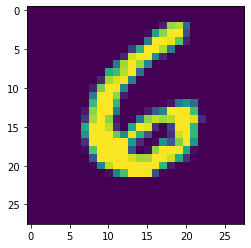

In [14]:
fig, ax = plt.subplots()
ax.imshow(data_X[idx_start:idx_end].reshape(28,28))

In [15]:
print('Klasifikasi menurut ANN adalah angka ', str(np.argmax(pred)))

Klasifikasi menurut ANN adalah angka  6


In [16]:
data_sendiri = plt.imread('check_data_sendiri_2.png')

In [17]:
data_sendiri.shape

(731, 616, 4)

In [18]:
from skimage import color
from skimage.transform import rescale, resize, downscale_local_mean

image = color.rgb2gray(data_sendiri[:,:,1:4])
image = image/np.max(image)

In [19]:
image_resized = resize(image, (28,28),
                       anti_aliasing=True) 

In [20]:
img = (image_resized)

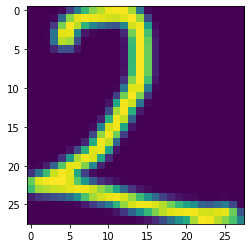

In [21]:
plt.imshow(img)

In [22]:
 l2, pred = forwardpropogation(img.reshape(1,-1)  , T1, T2)

In [23]:
np.argmax(pred)

3